In [14]:
import os
import sklearn
from sklearn.datasets import load_iris
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt

#To make the notebook's output stabel across runs
np.random.seed(42)

#Uses Jupyter's own backend to plot
%matplotlib inline

#To make pretty figures
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

#Path to saving images
IMAGE_PATH = os.path.join("images")
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(fig_id, fig_extension="png", tight_layout=True, resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure,", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Most applications of Machine Learning today are based on supervised learning, yet the vast majority of the available data is unlabeled: **we have input feature X, but we don't have the labels y.** Therefore, there is a huge potential in unsupervised learning.

Labeling data requires human experts to go through all the data, which is long costly and tedious task, even for a small subset from of a large dataset. Thus the labeled dataset will quite small, resulting in a poor performance from a classifier. Additionally, every time a company makes any changes to its products, the whole process will need to be started from scratch. 

**Unsupervised learning aims to exploit the unlabeled data without needing humans to label every instance in the dataset/subset.**

Dimensionality reduction is one of the common tasks for unsupervised learning and was discussed in a previous notebook. Thus, we'll focus on a few more unsupervised learning tasks and algorithms:
- **Clustering**
    - The goal is to group similar instacnes together into _clusters_. Clustering is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction and more.

- **Anomaly detection**
    - The objective is to learn what "normal" data looks like, and then use that to detect abnormal instances, such as defective items on a production line or a new trend in a time series.

- **Density estimation**
    - This is the task of estimating the _probabilty density function_ (PDF) of the random process that generated the dataset. Density estimation is commonly used for anomaly detection: instances that are located in very low-dimensional regions are more likely to be anomalies. It's also useful for data analysis and visualization.

We'll look at **clustering** first, using K-Means and DBSCAN. Then, discuss Gaussian mixture models and see how they can be used for density estimation, clustering and anomaly detection

# Section: Clustering

***Clustering*** is a task that identifies similar instances and assigning them to _clusters_ or groups of similar instances. It's just like classification, but clustering is an **unsupervised task.** 

In the following figure (figure 9-1), **on the left** is the iris dataset, where each instance's species is represented with a different marker. It's a labeled dataset, so classfication algorithms such as Logistic Regression, SVMs or Random Forest classfiers are well suited.

**On the righ** is the same dataset, but without labels, thus classifications algorithms are of no use. This is where clustering algorithms comes in, many of them can easily detect the lower-left cluster. 

The dataset has two additional features (sepal length and width), not represented here, and clustering algorithms can make good use of all features, so in fact they identify the three clusters fairly well - when we use Gaussian mixture model, only 5/150 are assigned to the wrong cluster (96.66% success rate).

In [4]:
iris = load_iris()
X = iris.data
y = iris.target
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Saving figure, Unsupervised Learning Techniques - Classification vs clustering


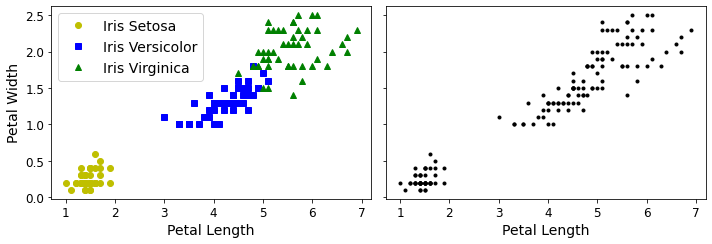

Figure 9-1


In [10]:
plt.figure(figsize=(10, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris Setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris Versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris Virginica")
plt.xlabel("Petal Length", fontsize=14)
plt.ylabel("Petal Width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal Length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("Unsupervised Learning Techniques - Classification vs clustering")
plt.show()
print("Figure 9-1")

    - A Gaussian mixture model can help separate these clusters pretty well using all 4 features: petal length and width, and sepal length and width

In [13]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

    - Let's map each cluster to a class. We'll pick the most common class for each cluster (using the scipy.stats.mode() function)

In [15]:
mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode[0]] = class_id
mapping

{1: 0, 2: 1, 0: 2}